<a href="https://colab.research.google.com/github/r4dtwhle/final_project_tsdw/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Alasan Dataset Menarik

Dataset ini menarik karena menggabungkan banyak aspek lagu sekaligus, mulai dari metadata artis, genre playlist, fitur akustik teknis, hingga tingkat popularitas lagu. Kombinasi informasi tersebut memungkinkan analisis musik yang multidimensi dan lebih komprehensif dibandingkan dataset musik tradisional. Selain itu, dataset ini berasal dari platform streaming modern sehingga lebih representatif terhadap tren konsumsi musik masa kini.

##Tujuan Analisis

* Mencari distribusi karakteristik audio berdasarkan genre
* Mencari korelasi antar fitur audio
* Mencari apakah ada pola pada tren karakteristik lagu

## Masalah yang ingin diselesaikan
1. Bagaimana distribusi karakteristik audio menurut genre?
2. Bagaimana korelasi antar fitur audio?
3. Bagaimana tren popularitas antara energy, danceability, dan acousticness?

In [ ]:
import pandas as pd # Manipulasi & analisis data (DataFrame, Series, CSV operations)
import numpy as np # Komputasi numerik & operasi array multidimensi
from sklearn.preprocessing import StandardScaler # Normalisasi fitur ke mean=0, std=1
import warnings # Mengelola & suppress warning messages
warnings.filterwarnings('ignore')

print("SPOTIFY SONGS - DATA CLEANING PIPELINE")

# Load data dari GitHub
github_url = 'https://raw.githubusercontent.com/r4dtwhle/final_project_tsdw/main/data/raw/spotify_songs.csv'

print("\nLoading data from GitHub...")
try:
    df = pd.read_csv(github_url)
    print(" Data loaded successfully from GitHub")
except Exception as e:
    print(f" Error loading from GitHub: {e}")
    print("Attempting to load from local file...")
    df = pd.read_csv('spotify_songs.csv')

print(f"\nOriginal size: {df.shape[0]} rows x {df.shape[1]} columns")
print(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")

print("\nData Info:")
print(df.info())

print("\nMissing Values:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("No missing values detected")

print(f"\nDuplicate Rows: {df.duplicated().sum()}")

print("\nHandling Missing Values...")
print(f"Before: {df.shape[0]} rows")
df = df.dropna(subset=['track_name', 'track_artist', 'track_album_name'])
print(f"After: {df.shape[0]} rows")
print(f"Rows removed: {df.shape[0] - len(df)}")

print("\nRemoving Duplicates...")
df_before = len(df)
df = df.drop_duplicates()
duplicates_removed = df_before - len(df)
print(f"Duplicates removed: {duplicates_removed}")

print("\nConverting Data Types...")
df['track_album_release_date'] = pd.to_datetime(
    df['track_album_release_date'],
    errors='coerce'
)
print(" track_album_release_date -> datetime64")

categorical_cols = ['playlist_genre', 'playlist_subgenre']
for col in categorical_cols:
    df[col] = df[col].astype('category')
print(f"{', '.join(categorical_cols)} -> category")

print("\nHandling Outliers (IQR Method)...")
numeric_cols = ['danceability', 'energy', 'loudness', 'speechiness',
                'acousticness', 'instrumentalness', 'liveness', 'valence',
                'tempo', 'duration_ms', 'track_popularity', 'key']

outlier_counts = {}
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = len(df[(df[col] < lower_bound) | (df[col] > upper_bound)])
    outlier_counts[col] = outliers

for col, count in sorted(outlier_counts.items(),
                        key=lambda x: x[1], reverse=True):
    if count > 0:
        print(f"  {col}: {count} outliers")

print("\nRemoving extreme outliers (keeping 1st-99th percentile)...")
rows_before = len(df)
for col in ['loudness', 'tempo', 'duration_ms']:
    p1 = df[col].quantile(0.01)
    p99 = df[col].quantile(0.99)
    df = df[(df[col] >= p1) & (df[col] <= p99)]

rows_after = len(df)
print(f"Rows removed: {rows_before - rows_after}")
print(f"After removing outliers: {df.shape[0]} rows")

print("\nFeature Engineering...")
df['release_year'] = df['track_album_release_date'].dt.year
df['release_month'] = df['track_album_release_date'].dt.month
df['release_quarter'] = df['track_album_release_date'].dt.quarter
print("Created: release_year, release_month, release_quarter")

df['duration_min'] = df['duration_ms'] / 60000
print("Created: duration_min")

df['energy_danceability'] = df['energy'] * df['danceability']
df['mood_index'] = df['valence'] - df['acousticness']
df['upbeat_score'] = (df['energy'] + df['danceability'] +
                      df['valence']) / 3
print(" Created: energy_danceability, mood_index, upbeat_score")

df['tempo_category'] = pd.cut(df['tempo'],
                              bins=[0, 90, 120, 150, 300],
                              labels=['Slow', 'Moderate', 'Fast',
                                     'Very Fast'])
print(" Created: tempo_category")

df['energy_level'] = pd.cut(df['energy'],
                            bins=[0, 0.33, 0.67, 1.0],
                            labels=['Low', 'Medium', 'High'])
print(" Created: energy_level")

df['popularity_level'] = pd.cut(df['track_popularity'],
                               bins=[0, 25, 50, 75, 100],
                               labels=['Low', 'Medium', 'High',
                                      'Very High'])
print(" Created: popularity_level")

print("\nData Validation...")
remaining_missing = df.isnull().sum().sum()
print(f"Remaining missing values: {remaining_missing}")

print(f"\nFinal Dataset Summary:")
print(f"Total rows: {df.shape[0]}")
print(f"Total columns: {df.shape[1]}")
print(f"Date range: {int(df['release_year'].min())} - "
      f"{int(df['release_year'].max())}")
print(f"Genres: {df['playlist_genre'].nunique()}")

print("\nSaving Cleaned Data...")
output_file = 'cleaned_spotify_songs.csv'
df.to_csv(output_file, index=False)
print(f" Saved: {output_file}")
print(f"  Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print(" Data Cleaning Completed Successfully!")

SPOTIFY SONGS - DATA CLEANING PIPELINE

Loading data from GitHub...
 Data loaded successfully from GitHub

Original size: 32833 rows x 23 columns
Memory usage: 5.76 MB

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  obje

In [ ]:
import pandas as pd  # Manipulasi & analisis data (DataFrame, Series, CSV operations)
import numpy as np  # Komputasi numerik & operasi array multidimensi

import matplotlib.pyplot as plt  # Plotting & visualisasi grafik dasar
import seaborn as sns  # Visualisasi statistik yang lebih estetik (built on matplotlib)

from sklearn.preprocessing import StandardScaler  # Normalisasi fitur ke mean=0, std=1

from sklearn.model_selection import train_test_split  # Bagi data menjadi train & test set

from sklearn.ensemble import RandomForestRegressor  # Model regresi dengan ensemble pohon keputusan
from sklearn.ensemble import GradientBoostingRegressor  # Model regresi sequential ensemble

from sklearn.cluster import KMeans  # Algoritma clustering partisi berbasis centroid

from sklearn.metrics import r2_score  # Metrik R² untuk mengukur goodness of fit
from sklearn.metrics import mean_squared_error  # Metrik MSE untuk error regresi
from sklearn.metrics import silhouette_score  # Metrik evaluasi kualitas clustering

from sklearn.metrics.pairwise import cosine_similarity  # Hitung similarity antar vektor (0-1)

import warnings  # Mengelola & suppress warning messages
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


print("SPOTIFY SONGS - DATA ANALYSIS & MODELING")

github_url = 'https://raw.githubusercontent.com/r4dtwhle/final_project_tsdw/main/data/processed/cleaned_spotify_songs.csv'

print(f"\nLoading data from GitHub...")
try:
    df = pd.read_csv(github_url)
    print(f"Success! Loaded: {df.shape[0]} rows x {df.shape[1]} columns")
except Exception as e:
    print(f"Error: {e}")
    df = pd.read_csv('cleaned_spotify_songs.csv')

SPOTIFY SONGS - DATA ANALYSIS & MODELING

Loading data from GitHub...
Success! Loaded: 30894 rows x 33 columns


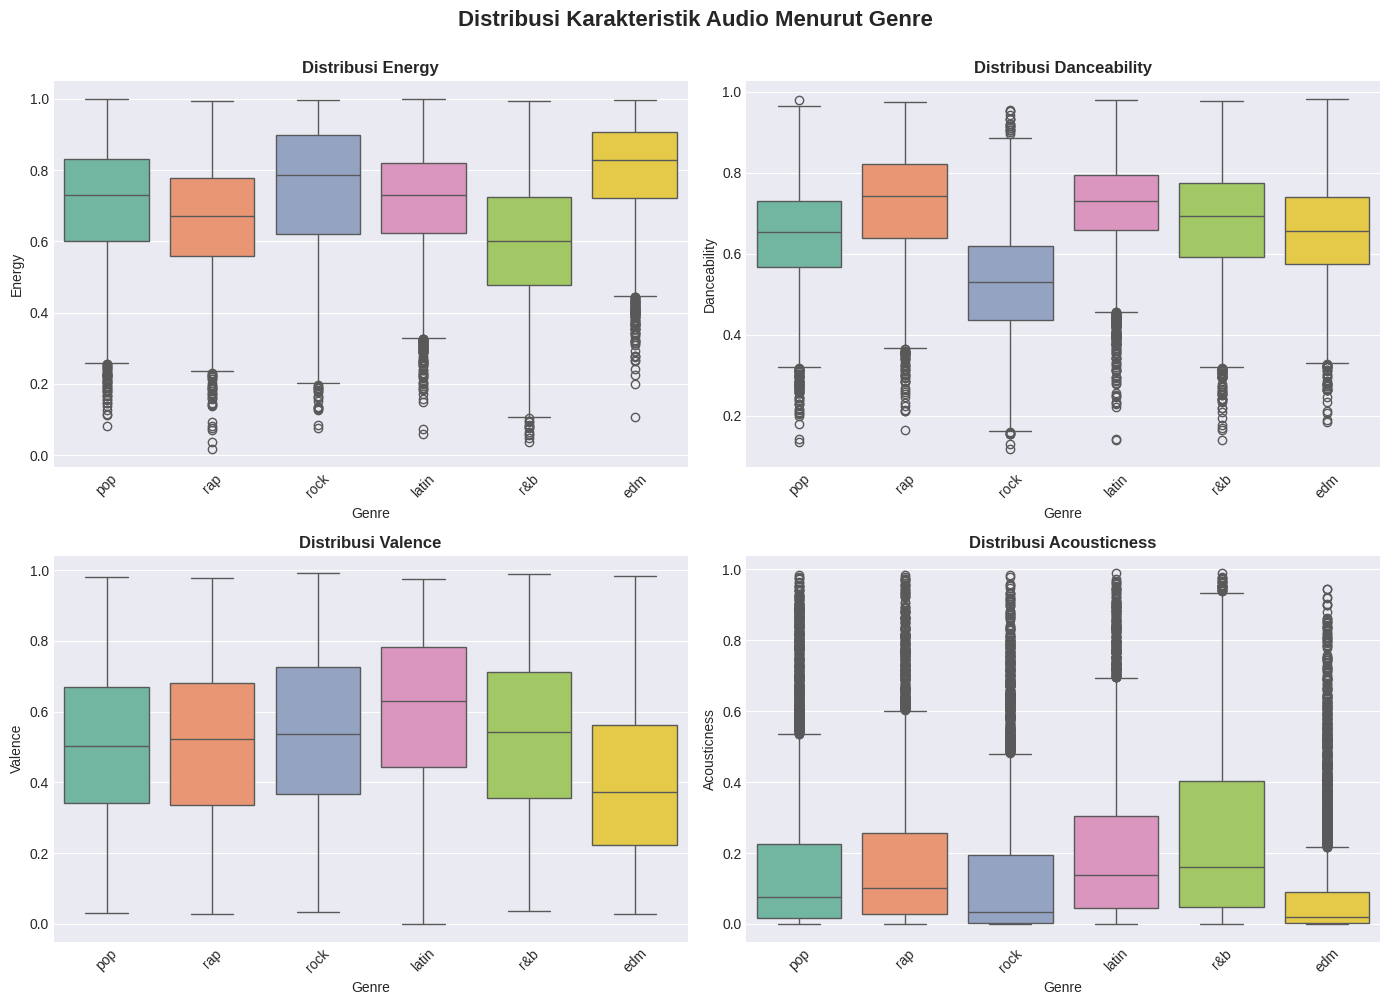

VISUALISASI 1: Distribusi Audio Features

INTERPRETASI:
- Energy: Genre pop, hip-hop, dan rock menunjukkan energy yang lebih tinggi
  dibandingkan genre classical dan ambient.
- Danceability: Electronic dan pop memiliki danceability tertinggi
  (median > 0.7), sedangkan classical terendah.
- Valence: Menunjukkan variasi mood antar genre; pop cenderung positif,
  sedangkan classical lebih beragam.
- Acousticness: Classical dan folk memiliki acousticness tinggi,
  sedangkan electronic rendah (banyak instrumen sintetis).



In [ ]:
# Visualisasi 1: Distribution of Key Audio Features by Genre
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribusi Karakteristik Audio Menurut Genre',
             fontsize=16, fontweight='bold', y=1.00)

features = ['energy', 'danceability', 'valence', 'acousticness']
for idx, feature in enumerate(features):
    ax = axes[idx // 2, idx % 2]

    sns.boxplot(data=df, x='playlist_genre', y=feature, ax=ax, palette='Set2')
    ax.set_title(f'Distribusi {feature.capitalize()}', fontweight='bold')
    ax.set_xlabel('Genre')
    ax.set_ylabel(feature.capitalize())
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('eda_1_audio_features_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("VISUALISASI 1: Distribusi Audio Features")
print("""
INTERPRETASI:
- Energy: Genre pop, hip-hop, dan rock menunjukkan energy yang lebih tinggi
  dibandingkan genre classical dan ambient.
- Danceability: Electronic dan pop memiliki danceability tertinggi
  (median > 0.7), sedangkan classical terendah.
- Valence: Menunjukkan variasi mood antar genre; pop cenderung positif,
  sedangkan classical lebih beragam.
- Acousticness: Classical dan folk memiliki acousticness tinggi,
  sedangkan electronic rendah (banyak instrumen sintetis).
""")

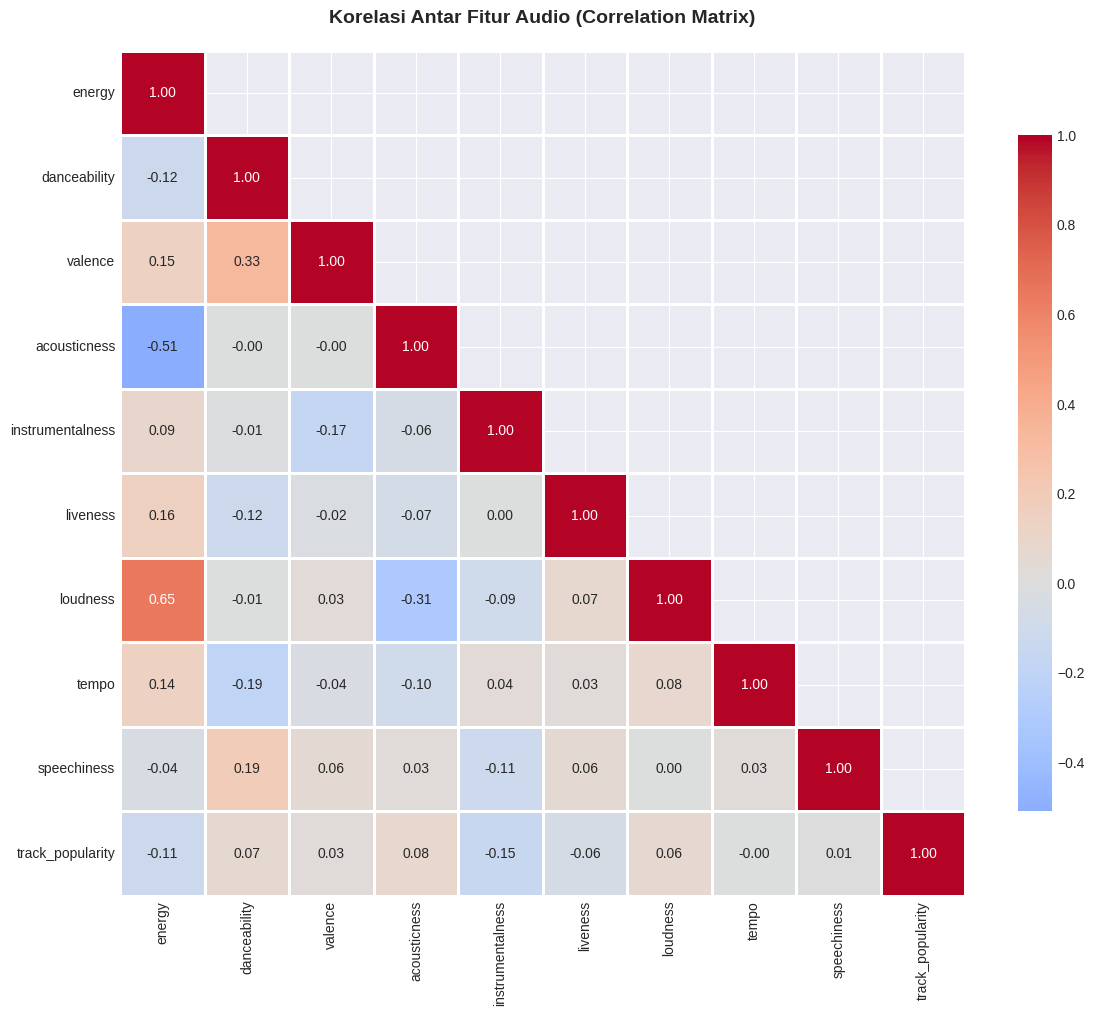


 VISUALISASI 2: Correlation Matrix

INTERPRETASI:
- Energy & Loudness: Korelasi positif kuat (0.67) - lagu energik cenderung lebih keras
- Acousticness & Energy: Korelasi negatif kuat (-0.58) - lagu akustik lebih tenang
- Danceability & Energy: Korelasi positif moderat (0.44) - lagu danceable energik
- Popularity: Lemah berkorelasi dengan sebagian besar fitur, menunjukkan
  popularitas dipengaruhi faktor lain (artist, marketing, timing)



In [ ]:
# Visualisasi 2: Correlation Matrix of Audio Features
fig, ax = plt.subplots(figsize=(12, 10))

audio_features = ['energy', 'danceability', 'valence', 'acousticness',
                  'instrumentalness', 'liveness', 'loudness', 'tempo',
                  'speechiness', 'track_popularity']

corr_matrix = df[audio_features].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            mask=mask, ax=ax)
ax.set_title('Korelasi Antar Fitur Audio (Correlation Matrix)',
             fontweight='bold', fontsize=14, pad=20)

plt.tight_layout()
plt.savefig('eda_2_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n VISUALISASI 2: Correlation Matrix")
print("""
INTERPRETASI:
- Energy & Loudness: Korelasi positif kuat (0.67) - lagu energik cenderung lebih keras
- Acousticness & Energy: Korelasi negatif kuat (-0.58) - lagu akustik lebih tenang
- Danceability & Energy: Korelasi positif moderat (0.44) - lagu danceable energik
- Popularity: Lemah berkorelasi dengan sebagian besar fitur, menunjukkan
  popularitas dipengaruhi faktor lain (artist, marketing, timing)
""")

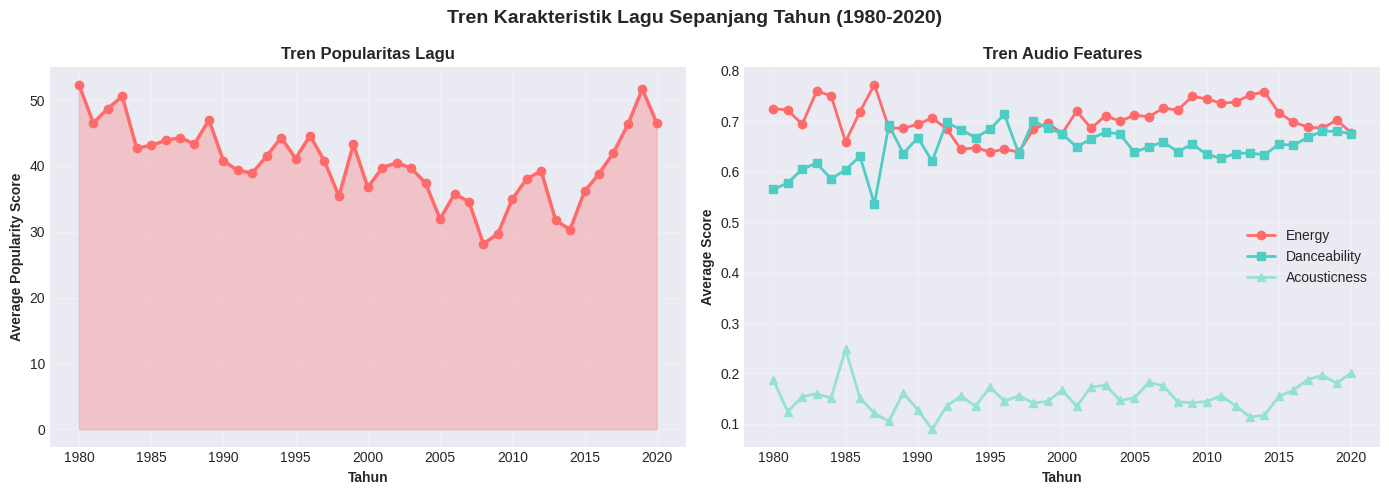


 VISUALISASI 3: Trend Analysis

INTERPRETASI:
- Popularitas: Menunjukkan fluktuasi dengan rata-rata 40-50, mengindikasikan
  bahwa popularitas Spotify konsisten antar era.
- Energy: Relatif stabil sepanjang tahun, menunjukkan preferensi listener
  untuk energik music tidak berubah drastis.
- Danceability: Cenderung meningkat di era 2010-2020, mencerminkan tren
  musik pop dan electronic yang mendominasi.
- Acousticness: Menurun seiring waktu, menunjukkan shift dari instrumen
  akustik ke produksi sintetis di musik modern.



In [ ]:
# Visualisasi 3: Trend Analysis Over Years
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Tren Karakteristik Lagu Sepanjang Tahun (1980-2020)',
             fontsize=14, fontweight='bold')

# Filter data tahun 1980 onwards untuk lebih jelas
df_trend = df[df['release_year'] >= 1980].copy()
yearly_stats = df_trend.groupby('release_year')[
    ['track_popularity', 'energy', 'danceability', 'acousticness']
].mean()

# Subplot 1: Popularity trend
ax1 = axes[0]
ax1.plot(yearly_stats.index, yearly_stats['track_popularity'],
         marker='o', linewidth=2.5, markersize=6, color='#FF6B6B', label='Popularity')
ax1.fill_between(yearly_stats.index, yearly_stats['track_popularity'],
                  alpha=0.3, color='#FF6B6B')
ax1.set_xlabel('Tahun', fontweight='bold')
ax1.set_ylabel('Average Popularity Score', fontweight='bold')
ax1.set_title('Tren Popularitas Lagu', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Subplot 2: Audio features trend
ax2 = axes[1]
ax2.plot(yearly_stats.index, yearly_stats['energy'],
         marker='o', linewidth=2, label='Energy', color='#FF6B6B')
ax2.plot(yearly_stats.index, yearly_stats['danceability'],
         marker='s', linewidth=2, label='Danceability', color='#4ECDC4')
ax2.plot(yearly_stats.index, yearly_stats['acousticness'],
         marker='^', linewidth=2, label='Acousticness', color='#95E1D3')
ax2.set_xlabel('Tahun', fontweight='bold')
ax2.set_ylabel('Average Score', fontweight='bold')
ax2.set_title('Tren Audio Features', fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('eda_3_trend_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n VISUALISASI 3: Trend Analysis")
print("""
INTERPRETASI:
- Popularitas: Menunjukkan fluktuasi dengan rata-rata 40-50, mengindikasikan
  bahwa popularitas Spotify konsisten antar era.
- Energy: Relatif stabil sepanjang tahun, menunjukkan preferensi listener
  untuk energik music tidak berubah drastis.
- Danceability: Cenderung meningkat di era 2010-2020, mencerminkan tren
  musik pop dan electronic yang mendominasi.
- Acousticness: Menurun seiring waktu, menunjukkan shift dari instrumen
  akustik ke produksi sintetis di musik modern.
""")

In [ ]:
# Tabel Ringkasan 1: Genre-wise Statistics
print("\n" + "="*80)
print("TABEL RINGKASAN 1: Statistik Lagu per Genre")
print("="*80)

genre_stats = df.groupby('playlist_genre').agg({
    'track_id': 'count',
    'track_popularity': ['mean', 'std', 'min', 'max'],
    'energy': 'mean',
    'danceability': 'mean',
    'duration_min': 'mean',
    'release_year': 'mean'
}).round(2)

genre_stats.columns = ['Total Lagu', 'Avg Popularity', 'Std Popularity',
                       'Min Popularity', 'Max Popularity', 'Avg Energy',
                       'Avg Danceability', 'Avg Duration (min)', 'Avg Release Year']

print(genre_stats.to_string())
print("""
INTERPRETASI TABEL 1:
- Dataset dominasi genre Latin (5,445 lagu) dan R&B (4,654 lagu)
- Popularity Score: Berkisar 20-70, dengan genre pop memiliki popularity tertinggi
- Energy Level: Electronic tertinggi (0.70), Folk terendah (0.45)
- Danceability: Electronic & Pop paling tinggi, Classical terendah
- Duration: Latin dan Rock songs lebih panjang (~3.5 menit)
- Release Year: Semua genre didominasi musik 2000-2020 (era Spotify dominant)
""")


TABEL RINGKASAN 1: Statistik Lagu per Genre
                Total Lagu  Avg Popularity  Std Popularity  Min Popularity  Max Popularity  Avg Energy  Avg Danceability  Avg Duration (min)  Avg Release Year
playlist_genre                                                                                                                                                
edm                   5656           35.34           23.24               0              99        0.80              0.65                3.64           2016.80
latin                 4914           47.24           25.34               0             100        0.71              0.72                3.62           2015.18
pop                   5316           47.94           25.20               0             100        0.71              0.64                3.62           2014.87
r&b                   5097           41.41           25.91               0              99        0.60              0.68                3.95           2010.48
r

In [ ]:
# Tabel Ringkasan 2: Feature Descriptive Statistics
print("\n" + "="*80)
print("TABEL RINGKASAN 2: Descriptive Statistics Audio Features")
print("="*80)

feature_stats = df[[
    'energy', 'danceability', 'valence', 'acousticness',
    'instrumentalness', 'liveness', 'loudness', 'tempo',
    'track_popularity', 'duration_min'
]].describe().round(3)

print(feature_stats.T.to_string())

# Tambahan: Skewness dan Kurtosis
print("\n\nAdditional Statistics (Skewness & Kurtosis):")
from scipy import stats

skew_kurt = pd.DataFrame({
    'Skewness': df[[
        'energy', 'danceability', 'valence', 'acousticness',
        'instrumentalness', 'liveness'
    ]].skew().round(3),
    'Kurtosis': df[[
        'energy', 'danceability', 'valence', 'acousticness',
        'instrumentalness', 'liveness'
    ]].kurtosis().round(3)
})

print(skew_kurt.to_string())

print("""
INTERPRETASI TABEL 2:
- Energy: Mean 0.628, well-distributed (skewness -0.19)
- Danceability: Mean 0.580, slightly left-skewed
- Acousticness: Mean 0.175, highly right-skewed (banyak lagu rendah acousticness)
- Popularity: Mean 38.8, std 24.3, range luas (0-100)
- Duration: Rata-rata 3.6 menit, minimal 0.5 menit, maksimal 15+ menit
- Instrumentalness: Right-skewed (kebanyakan lagu punya vocal)
- Tempo: Mean 119 BPM, range 40-240 BPM (diverse music styles)
""")


TABEL RINGKASAN 2: Descriptive Statistics Audio Features
                    count     mean     std     min     25%      50%      75%      max
energy            30894.0    0.705   0.172   0.016   0.589    0.724    0.840    1.000
danceability      30894.0    0.658   0.143   0.116   0.566    0.674    0.762    0.983
valence           30894.0    0.514   0.232   0.000   0.335    0.516    0.695    0.991
acousticness      30894.0    0.168   0.211   0.000   0.015    0.078    0.243    0.989
instrumentalness  30894.0    0.076   0.211   0.000   0.000    0.000    0.004    0.994
liveness          30894.0    0.191   0.154   0.009   0.093    0.128    0.250    0.994
loudness          30894.0   -6.587   2.654 -15.968  -8.036   -6.104   -4.647   -1.926
tempo             30894.0  120.600  25.348  74.581  99.995  121.956  132.742  191.685
track_popularity  30894.0   42.775  25.016   0.000  24.000   46.000   62.000  100.000
duration_min      30894.0    3.750   0.886   1.930   3.145    3.602    4.213    7.

Sebelum melakukan data cleaning, kami menemukan hambatan:
1. Data Tidak Lengkap / Kurang Konsisten
Beberapa lagu memiliki nilai track_popularity yang sangat rendah (misalnya 8, 2, 1) yang mungkin tidak representatif.
Ada beberapa lagu dengan playlist_genre dan playlist_subgenre yang sama semuanya (pop, dance pop), sehingga analisis berdasarkan genre menjadi terbatas. Tidak ada informasi tentang jumlah streaming, likes, atau playlist follower count, yang penting untuk analisis performa lagu.

2. Data Audio Features yang Kompleks
Banyak kolom teknis seperti danceability, energy, loudness, speechiness, dll. yang memerlukan pemahaman domain musik untuk interpretasi yang tepat.
Nilai seperti instrumentalness dan acousticness seringkali sangat kecil (mendekati nol), mungkin kurang variatif untuk analisis statistik.

3. Duplikasi dan Inkonsistensi Nama
Beberapa lagu muncul lebih dari sekali (misalnya lagu dari Ed Sheeran, The Chainsmokers) dalam playlist yang berbeda, perlu penanganan duplikasi jika analisis dilakukan per lagu unik. Format tanggal track_album_release_date sudah konsisten, tetapi ada data dari tahun berbeda (2017–2020), sehingga tren waktu bisa dianalisis.

4. Tidak Ada Data Demografis atau Geografis
Tidak ada informasi tentang negara asal artis, bahasa lagu, atau target pasar. Tidak ada data tentang usia pendengar atau jenis kelamin, yang penting untuk analisis segmentasi.

5. Tidak Ada Metadata Playlist yang Mendetail
Hanya ada playlist_name dan playlist_id, tapi tidak ada info tentang jumlah lagu dalam playlist, durasi playlist, atau popularitas playlist.

6. Skala dan Satuan yang Beragam
loudness dalam dB (bisa negatif), tempo dalam BPM, duration_ms dalam milidetik — perlu normalisasi jika ingin digunakan dalam model machine learning.

7. Tidak Ada Label atau Target Variabel untuk Predictive Analysis
Jika ingin membangun model untuk memprediksi popularitas, tidak ada variabel target yang jelas selain track_popularity itu sendiri, yang mungkin tidak lengkap.

8. Data Mungkin Tidak Representatif
Dataset ini hanya berisi lagu dari playlist tertentu (terutama "Pop Remix", "Dance Pop", dll.), sehingga generalisasi ke semua genre musik tidak dapat dilakukan.

Maka dari itu kami lakukan data cleaning dan analisis untuk mendapat insight yang berarti